# 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook", font_scale=1.2)

In [2]:
train = pd.read_csv('./data/ads_train.csv')
train.head()

,Unnamed: 0,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
0,1,0,NaN,1,0.0,0.00000,0.0,0.00000,106,106,0,0,169,2130,0
1,2,0,NaN,1,0.0,0.00000,0.0,0.00000,6,6,0,0,150,539,0
2,3,0,NaN,2,0.0,0.50000,0.0,-101.14930,101,101,0,1,103,362,0
3,4,0,NaN,1,0.0,0.00000,0.0,0.00000,42,42,0,0,17,35,0
4,5,0,NaN,3,0.0,45.47917,0.0,-34.14473,64,64,0,1,100,298,0


# 2. Data Cleaning

## 2.1 Preliminary process

Delete first column, which is just record id column

In [3]:
del train['Unnamed: 0']

I suspect that there is something wrong with `last_buy` and `last_visit` column. So I took a look at the scatterplot.

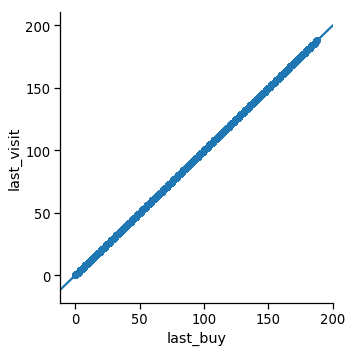

In [4]:
sns.lmplot(x="last_buy", y="last_visit", data=train)

In [5]:
print('There are ', sum(train.last_buy != train.last_visit), ' records with different last_buy and last_visit values')

There are  0  records with different last_buy and last_visit values


<font color='blue'> Therefore, there might be either coding error or duplicated attributes for `last_buy` and `last_visit`. I would keep only one of them in the model </font>

## 2.2 Missing Value /  Zero values

In [6]:
train.describe()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
count,38209.000000,1620.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000
mean,0.042398,1.239506,1.868199,0.197411,5.862179,-0.174376,-10.136685,64.657384,64.657384,0.005967,0.277526,86.594624,723.834515,0.004502
std,0.201499,0.840259,2.996675,3.855662,17.726455,4.784059,31.796845,53.453475,53.453475,0.077018,0.447784,61.941089,1286.380572,0.066943
min,0.000000,1.000000,0.000000,0.000000,0.000000,-181.923800,-187.615600,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,18.000000,0.000000,0.000000,30.000000,127.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,0.000000,0.000000,75.000000,319.000000,0.000000
75%,0.000000,1.000000,2.000000,0.000000,0.125000,0.000000,0.000000,105.000000,105.000000,0.000000,1.000000,155.000000,803.000000,0.000000
max,1.000000,15.000000,84.000000,174.625000,184.916700,84.285710,91.401920,188.000000,188.000000,1.000000,1.000000,206.000000,37091.000000,1.000000


- The `uniq_urls` column should not have negative values. There might be some unknown reason for coding them as '-1'. 
- I added another column `na_uniq_urls` to capture the unknown factor.

In [7]:
train['na_uniq_urls'] = train['uniq_urls'].map(lambda x: 1 if x == -1 else 0)

---

The first step is to investigate the missing values/ zero values in the dataset.

In [8]:
print('----The training set has a total of {0} records----\n'.format(len(train)))
print('----Perent of missing values----')
train.isnull().sum()/len(train)*100

----The training set has a total of 38209 records----

----Perent of missing values----


isbuyer                 0.000000
buy_freq               95.760161
visit_freq              0.000000
buy_interval            0.000000
sv_interval             0.000000
expected_time_buy       0.000000
expected_time_visit     0.000000
last_buy                0.000000
last_visit              0.000000
multiple_buy            0.000000
multiple_visit          0.000000
uniq_urls               0.000000
num_checkins            0.000000
y_buy                   0.000000
na_uniq_urls            0.000000
dtype: float64

***Finding***: Only `buy_freq` column has **NA** value.

Then take a look at zero values

In [9]:
print('----Perent of zero values----')
(train==0).sum()/len(train)*100

----Perent of zero values----


isbuyer                95.760161
buy_freq                0.000000
visit_freq              0.164883
buy_interval           99.403282
sv_interval            72.247376
expected_time_buy      99.403282
expected_time_visit    72.247376
last_buy                3.266246
last_visit              3.266246
multiple_buy           99.403282
multiple_visit         72.247376
uniq_urls               1.300741
num_checkins            0.000000
y_buy                  99.549844
na_uniq_urls           98.484650
dtype: float64

Some of the attributes with **NA** or **0** values may have some special indications. 


First take a look at ***buy*** behavior.

In [10]:
NumNonZero = lambda x: sum(x != 0)

In [11]:
train['buy_freq_discrete'] = train['buy_freq'].map(
            lambda x: 'NA' if np.isnan(x) else ('=1' if x == 1 else '>=2'))
train.groupby('buy_freq_discrete').agg({'isbuyer':NumNonZero,
            'expected_time_buy': NumNonZero,
            'buy_interval': NumNonZero,
            'multiple_buy': NumNonZero})

,isbuyer,expected_time_buy,buy_interval,multiple_buy
buy_freq_discrete,,,,
=1,1392,0.0,0.0,0
>=2,228,228.0,228.0,228
NA,0,0.0,0.0,0


The conclusion from the table above is:
- If `buy_freq` is **NA** or **1** / `multiple_buy` is **0**, then `expected_time_buy` and `buy_interval` are **0**. 
- We can fill in the **NA** on `buy_freq` with **0**. 

In [12]:
train['buy_freq'] = train['buy_freq'].fillna(0)

<font color=blue>**multiple_buy: If there are more than one past purchase, the value is 1. Else the value is 0. **</font>

---

Then take a look at ***visit*** behavior.

In [13]:
train['visit_freq_discrete'] = train['visit_freq'].map(
            lambda x: 'Zero' if x == 0 else ( '=1' if x == 1 else '>=2'))
train.groupby('visit_freq_discrete').agg({
            'expected_time_visit': NumNonZero,
            'sv_interval': NumNonZero,
            'multiple_visit': NumNonZero,
            'last_visit': NumNonZero})

,expected_time_visit,sv_interval,multiple_visit,last_visit
visit_freq_discrete,,,,
=1,0.0,0.0,0,27021
>=2,10604.0,10604.0,10604,9940
Zero,0.0,0.0,0,0


The conclusion from the table above is similar:
- If `visit_freq` is **0** or **1** / `multiple_visit` is **0**, then `expected_time_visit` and `sv_interval` are **0**. 

<font color=blue>**multiple_visit: If there are more than one past visit, the value is 1. Else the value is 0.**</font>

## 2.3 Attribute correlations

In [14]:
train['last_buy + expected_time_buy'] = train['last_buy'] + train['expected_time_buy']
train['last_visit + expected_time_visit'] = train['last_visit'] + train['expected_time_visit']

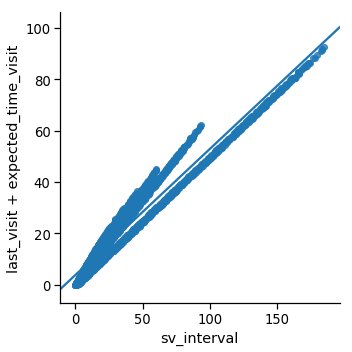

In [15]:
sns.lmplot(x="sv_interval", y = 'last_visit + expected_time_visit', data = train[train.expected_time_visit > 0])

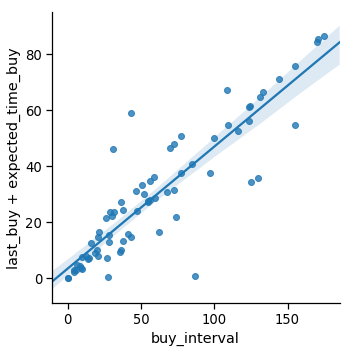

In [16]:
sns.lmplot(x="buy_interval", y = 'last_buy + expected_time_buy', data = train[train.expected_time_buy > 0])

There seem to be some linear relationships between:
- (`last_buy` + `expected_time_buy`) and `buy_interval`
- (`last_visit` + `expected_time_visit`) and `sv_interval`

So it can be inferred that:
- <font color=blue>**expected_time_buy**</font>: 


  * <font color=blue>If there is no more than one past purchase, value is 0.</font>
  
  * <font color=blue>If there is >=2 past purchases, then it represents the expected offset in days that a purchase should happen. The expectation is calculated based on past purchase intervals.</font>
    
  * <font color=blue>For example, "+5" means that a purchase is expected to happen 5 days later. "-5" means that a purchase is expected to happen 5 days earlier.</font>
  
- <font color=blue>**expected_time_visit**</font>: 


  * <font color=blue>If there is no more than one past visit, value is 0.</font>
  
  * <font color=blue>If there is >=2 past visits, then it represents the expected offset in days that a visit should happen. The expectation is calculated based on past visit intervals.</font>
    
  * <font color=blue>For example, "+5" means that a visit is expected to happen 5 days later. "-5" means that a visit is expected to happen 5 days earlier.</font>

# 3. Exploratory Analysis

First let's define ***categorical*** and ***continuous*** attributes:

In [17]:
categ_cols = ['isbuyer','multiple_buy','multiple_visit','na_uniq_urls']
conti_cols_buy = ['buy_freq','buy_interval','expected_time_buy', 'last_buy']
conti_cols_visit = ['visit_freq', 'sv_interval','expected_time_visit', 'last_visit']
conti_cols_other =['uniq_urls','num_checkins']
conti_cols =conti_cols_buy + conti_cols_visit + conti_cols_other
conti_cols =[x for x in conti_cols if x != 'last_buy'] # delete a duplicated/redundant attribute

Next take a look at the boxplot of all continuous variables. Note that zero values are excluded because they have special indication.

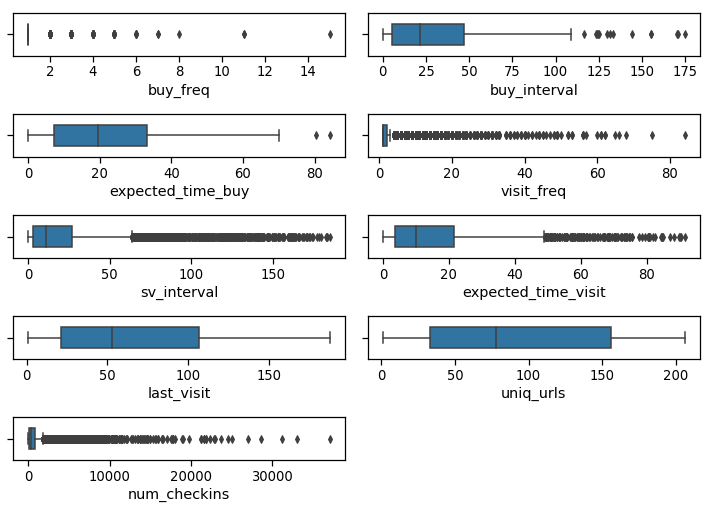

In [18]:
plt.figure(figsize=(10,8))
fig_no=1
for column in conti_cols:
    plt.subplot(6,2,fig_no)
    sns.boxplot(x=column, data=train[train[column]>0], width=0.5);
    fig_no+=1 
plt.tight_layout()

- Some variables such as `num_checkins`, `visit_freq`, `sv_interval` have quite a few extreme data points. The disribution of these attributes has a long right tail. 
- For now, I choose not to transform / remove outliers. I would prefer selecting model types more robust to outliers.

---

Now I would like to take a look at how the distributions of these attributes vary between buyers and non-buyers based on their past behavior.

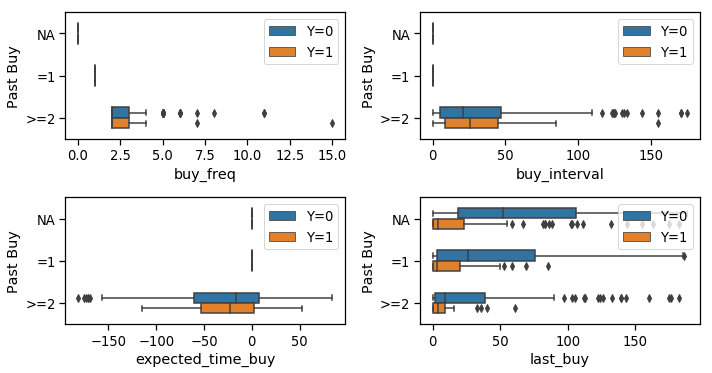

In [19]:
train['y_buy_label'] = train['y_buy'].map(lambda x : 'Y=1' if x == 1 else 'Y=0')
plt.figure(figsize=(10,15))
fig_no=1
for column in conti_cols_buy:
    plt.subplot(6,2,fig_no)
    sns.boxplot(x=column, y='buy_freq_discrete', hue = 'y_buy_label', data=train, width=0.5);
    fig_no+=1 
    plt.ylabel('Past Buy')
    plt.legend(loc='upper right')
plt.tight_layout()

- From the bottom right, we may find that actual buyers may have a smaller value on `last_buy` (i.e., they just made a  purchase recently)

---

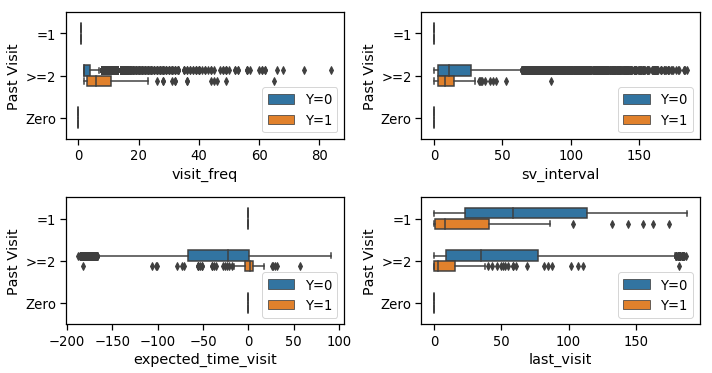

In [20]:
plt.figure(figsize=(10,15))
fig_no=1
for column in conti_cols_visit:
    plt.subplot(6,2,fig_no)
    sns.boxplot(x=column, y='visit_freq_discrete', hue = 'y_buy_label', data=train, width=0.5);
    fig_no+=1 
    plt.ylabel('Past Visit')
    plt.legend(loc='lower right')
plt.tight_layout()

- From top two figures, we may find that actual buyers may have higher `visit_freq` and lower `sv_interval`.
- From the bottom left, we may find that actual buyers may have a smaller value on `expected_time_visit` (i.e, they are expected to have a visit earlier )
- From the bottom right, we may find that actual buyer may have a smaller value on `last_visit` (i.e., they just made a visit recently)

---

- Below is a figure to demonstrate the distribution of categorical variables for all actual buyers (`y_buy`=1) 
- We may find that value **1** on all of the three attributes: `isbuyer`, `multiple_buy` and `multiple_visit` is very likely to increase chances of `y_buy`.

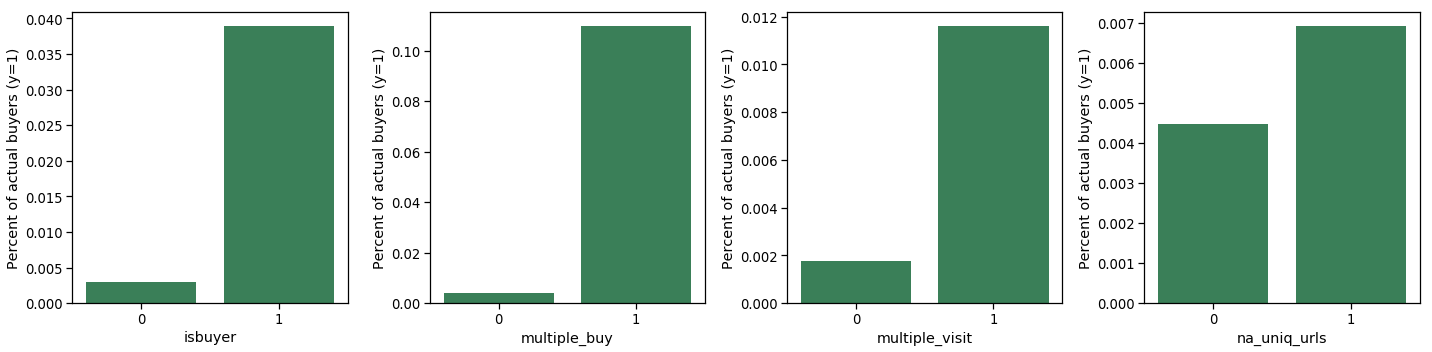

In [21]:
plt.figure(figsize=(20, 5))
fig_no=1
for column in categ_cols:
    plt.subplot(1,4,fig_no)
    sns.barplot(x=column, y='y_buy', data=train, estimator = np.mean, ci = None, color='seagreen')
    fig_no+=1
    plt.ylabel('Percent of actual buyers (y=1)')
plt.tight_layout()

# 4. Modelling

In [22]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve,auc, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

/Users/shiwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 4.1 Evaluation Metric

The following evaluation metric is considered:
- AUC (Area Under Curve)

It should be noted that in our training set, there are less than one percent actual buyers, so the classes are not balanced. Just using accuracy fails to account for the class imbalance. 
- AUC describes the probability that a randomly chosen positive example ranks above a randomly chosen negative example. ROC curve and AUC value will be a better option to select between models and tune model parameters.

## 4.2 Model 1 - logistic regression

I would like to start with logistic regression:
- Logistic regression is a typical type of regression having a binary response variable.
- Feature selection with Lasso can be combined with logistic regression to avoid over-fitting
- The estimated coefficients are more interpretable compared with other methods.


- The lasso regularization imposes penalty with same weights on the coefficients, so the variables need to be standardized for training. 
- **`GridCV`** is used to find the best regularization parameter by implementing a grid search for C using 5-fold cross-validation. AUC value is used as the score to select best parameter.

***Prepare Input data***

In [23]:
X_train = train[categ_cols + conti_cols]
y_train = train['y_buy']

***Perform 5-fold CV to select best penalty parameter***

Define possible C values from $10^{-4}$ to $10^4$

In [24]:
param_test_lr =  {'C' :[10 ** x for x in list(range(-4,5,1))]}
param_test_lr['C']

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

***Account for imbalanced class by assigning `class_weight` to be "balanced"***

Run GridCV with performance metric **AUC**

In [25]:
gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
    scoring = {'AUC': 'roc_auc'},
    cv = 5,
    n_jobs = 4, 
    refit = 'AUC')

gsearch_lr.fit(X_train / np.std(X_train, 0),y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)

***Visualize the effect of C***

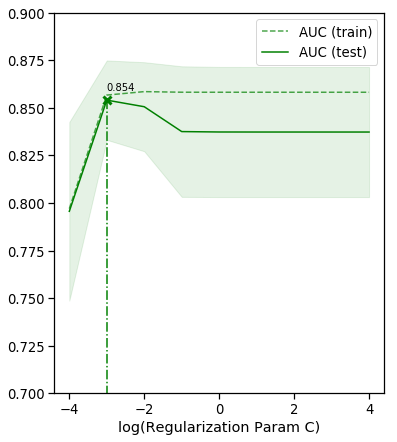

In [26]:
plt.figure(figsize=(13, 7))
plt.xlabel("Regularization Parameter")
plt.ylabel("Score")
plt.grid()

scoring={'AUC': 'f1'}
ax = plt.axes()
results = gsearch_lr.cv_results_

# Get the regular numpy array from the MaskedArray
X_axis = np.log10( np.array(results['param_C'].data, dtype=float))

for scorer, color, fig_no, ylim in zip(sorted(scoring), ['g'],[1],[[0.7,0.9]]):

    for sample, style in (('train', '--'), ('test', '-')):
        ax = plt.subplot(1,2,fig_no)
        ax.set_ylim(ylim)
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score,
                (X_axis[best_index], best_score + 0.005))
    ax.legend(loc="best")
    plt.xlabel("log(Regularization Param C)")
    
plt.grid('off')
plt.show()

***Select the best C to maximize AUC***

In [27]:
best_C = gsearch_lr.best_params_['C']
print('The best C is '+ str(best_C))

The best C is 0.001


In [28]:
best_AUC_lr = gsearch_lr.best_score_
print('The best AUC is '+ str(best_AUC_lr))                                                      

The best AUC is 0.854087067738905


***Refit the model with best `C`***

In [29]:
lr_ = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=1000,class_weight = 'balanced')
lr_ = lr_.fit(X = X_train / np.std(X_train, 0), y = y_train)

***Study attribute weights***

In [30]:
coef_df = pd.DataFrame({'variable':X_train.columns, 'coefficient':lr_.coef_[0]})
coef_df['sort'] = coef_df.coefficient.abs()
coef_df.sort_values(by = 'sort',ascending=0).drop('sort', axis=1)

,variable,coefficient
10,last_visit,-0.617843
2,multiple_visit,0.299463
11,uniq_urls,-0.256597
0,isbuyer,0.243112
7,visit_freq,0.214446
4,buy_freq,0.033998
1,multiple_buy,0.018018
3,na_uniq_urls,0.000000
5,buy_interval,0.000000
6,expected_time_buy,0.000000


Interpretation:
The follow top-5 factors may contribute to a higher probability of actual purchase (`y_buy` =1):
- Less days since last visit/purchase.
- Has multiple past visits
- Less unique url
- Has purchase before.
- Higher visit frequency


## 4.3 Model 2 - Gradient Boosting Tree

One main shortcoming of logistic regression is that it only considered the linear relationship between independent variable and the outcome (i.e., the decision boundary is linear). Decision tree captures the non-linear relationship by nature, and boosting algorithm would reduce the variance of decision tree by sequentially building weak classifiers, and aggregating them.

Parameter tuning need to be done before getting a fitted model. Grid search is again used to find the best value for the following parameters. A more complete parameter tuning can include other paramters as well. Here I have done a quick tuning for the parameters below.
- Learning Rate
- The maximum depth of the tree.
- Number of estimators

***Perform 5-fold CV to select best penalty parameter***

In [31]:
param_test_gb =  {
               'learning_rate': [10 ** x for x in list(range(-5,0,1))],
               'max_depth':range(1,8,2), 
               'n_estimators':range(30,120,20)}

***Account for class imbalance by assigning sample weights to each sample***

Minor class (Y=1) gets a much higher weight than major class (Y=0). The weight is calculated based on $N_{Y=0}/N_{Y=1}$

In [32]:
weights = [sum(y_train==0) / sum(y_train==1) if x == 1 else 1 for x in y_train]

In [33]:
gsearch_gb = GridSearchCV(estimator = GradientBoostingClassifier( 
    max_features='sqrt',
    random_state=11),  
param_grid = param_test_gb, scoring={'AUC': 'roc_auc'},cv=5,n_jobs=7, refit='AUC')
gsearch_gb.fit(X_train,y_train, sample_weight=weights)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=11, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=7,
       param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'max_depth': range(1, 8, 2), 'n_estimators': range(30, 120, 20)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)

***Select the best parameter set to maximize AUC***

In [34]:
print('The best parameter set is: ',
gsearch_gb.best_params_, '\n\n', 'The best AUC score is: ',
gsearch_gb.best_score_)

The best parameter set is:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 110} 

 The best AUC score is:  0.8625205714931461


***Refit the model with best parameters***

In [35]:
gb_ = GradientBoostingClassifier(learning_rate=gsearch_gb.best_params_['learning_rate'], 
                                 max_depth=gsearch_gb.best_params_['max_depth'], 
                                 max_features='sqrt',
                                 random_state=11,
                                 n_estimators=gsearch_gb.best_params_['n_estimators'])
gb_.fit(X_train, y_train, sample_weight = weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=110,
              presort='auto', random_state=11, subsample=1.0, verbose=0,
              warm_start=False)

***Study attribute importance***

Text(0,0.5,'Feature Importance Score')

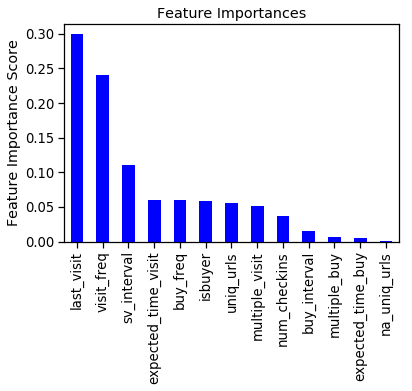

In [36]:
feat_imp = pd.Series(gb_.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', color='b')
plt.ylabel('Feature Importance Score')

The top 5 features are:
- last visit (*which is consistent with logistic regression results*)
- visit_freq
- sv_interval
- expected_time_visit
- buy_freq

## 4.4 Model Comparison

- The gradient boosting tree shows better performance during the CV tests (with AUC as evaluation metric, ***0.863*** vs. ***0.854***) compared with logistic regression. If prediction performance is the main goal, gradient boosting tree model should be used.
- The results from logistic regression are more interpretable. Although it doesn't give excellent performance, it could be useful to extract business insights from the model.

To help make the decision, we run the model again on the whole training data to study the Confusion Matrix. Note that model is developed based on CV datasets, not whole training set.

In [37]:
y_hat_lr = lr_.predict_proba(X = X_train / np.std(X_train, 0))[:,1]
preds_lr = lr_.predict(X = X_train)
CF = pd.DataFrame(confusion_matrix(y_train,preds_lr))
CF = CF / len(X_train)
print('Logisic Regression')
print('------------')
print(CF,'\n-----------')
print('Precision: ', precision_score(y_train,preds_lr))
print('Recall: ',recall_score(y_train,preds_lr))

Logisic Regression
------------
          0         1
0  0.990395  0.005104
1  0.004266  0.000236 
-----------
Precision:  0.04411764705882353
Recall:  0.05232558139534884


In [38]:
y_hat_gb = gb_.predict_proba(X = X_train)[:, 1]
preds_gb = gb_.predict(X = X_train)
CF = pd.DataFrame(confusion_matrix(y_train,preds_gb))
CF = CF / len(X_train)
print('Gradient Boosting Tree')
print('------------')
print(CF,'\n-----------')
print('Precision: ', precision_score(y_train,preds_gb))
print('Recall: ',recall_score(y_train,preds_gb))

Gradient Boosting Tree
------------
          0         1
0  0.842707  0.152791
1  0.000890  0.003612 
-----------
Precision:  0.023092369477911646
Recall:  0.8023255813953488



- For the purpose of this assignment, I believe recall score is more important since we want to identify potential buyers as much as we can. 
- **The gradient boosting tree model will be used for prediction of test dataset.**

# 5. Prediction

## 5.1 Apply same cleaning for testing set

In [41]:
raw_test = pd.read_csv('./data/ads_test.csv')
test=raw_test.copy()

In [42]:
del test['Unnamed: 0']
test['na_uniq_urls'] = test['uniq_urls'].map(lambda x: 1 if x == -1 else 0)
test['buy_freq'] = test['buy_freq'].fillna(0)

In [43]:
X_test = test[categ_cols + conti_cols]

## 5.2 Apply model to predict test dataset.

In [44]:
y_hat_gb = gb_.predict_proba(X = X_test)[:, 1]
preds_gb = gb_.predict(X = X_test)

## 5.3 Output results

In [45]:
raw_test['pred_prob'] = y_hat_gb
raw_test['pred_label'] = preds_gb
raw_test.to_csv('./result/output.csv')